In [1]:
import json
import numpy as np
import os

In [2]:
from pinn import *
from nn import NN
import numpy as np
from read_write import resolve_json, get_params_PINN, get_params_mat, get_last_modified_file

retrain_init = True
load_saved = True

torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
resolve_json('par.j2')

In [4]:
if retrain_init:
    %run initialization_NN.py

In [5]:
from initialize_matpar import to_matpar_PINN

E, rho, _ , nu = get_params_mat('par_resolved.json')

lam, mu = to_matpar_PINN(E, nu)

Lx, Ly, T, n_train, layers, dim_hidden, lr, epochs, weight_IN, weight_BOUND = get_params_PINN('par_resolved.json')

x_domain = np.array([0.0, Lx])/Lx
y_domain = np.array([0.0, Ly])/Lx
t_domain = np.array([0.0, T])/T

In [6]:
pinn = PINN(layers, dim_hidden, act=nn.Tanh()).to(device)

loss_fn = Loss(
    x_domain,
    y_domain,
    t_domain,
    n_train,
    return_adim(x_domain, t_domain, rho, mu, lam),
    initial_conditions,
    weight_IN,
    weight_BOUND
)

In [7]:
if not load_saved:
    pinn = PINN(layers, dim_hidden, act=nn.Tanh()).to(device)

    loss_fn = Loss(
        x_domain,
        y_domain,
        t_domain,
        n_train,
        return_adim(x_domain, t_domain, rho, mu, lam),
        initial_conditions,
        weight_IN,
        weight_BOUND
    )
    
    filename_model = get_last_modified_file('in_model')
    pretrained_model_dict = torch.load(filename_model, map_location=torch.device(device))

    pretrained_model = NN(layers, dim_hidden, 2, 1)
    pretrained_model.load_state_dict(pretrained_model_dict)

    for i in np.arange(len(pinn.middle_layers)):
        pinn_layer = pinn.middle_layers[i]
        pretrained_layer = pretrained_model.middle_layers[i]
        pinn.middle_layers[i].weight.data.copy_(pretrained_model.middle_layers[i].weight)
        pinn.middle_layers[i].bias.data.copy_(pretrained_model.middle_layers[i].bias)

    pinn_trained, loss_values = train_model(
    pinn, loss_fn=loss_fn, learning_rate=lr, max_epochs=epochs)

    current_time = get_current_time(fmt="%H:%M")

    folder = 'model'
    model_name = f'{lr}_{epochs}_{dim_hidden}_{current_time}.pth'
    model_path = os.path.join(folder, model_name)
    os.makedirs(folder, exist_ok=True)

    torch.save(pinn_trained.state_dict(), model_path)

In [8]:
if load_saved:
    pinn_trained = PINN(layers, dim_hidden, act=nn.Tanh()).to(device)
    filename = get_last_modified_file('model')
    pinn_trained.load_state_dict(torch.load(filename, map_location = device))

# Train new network with pretrained weights and biases in middle layers

In [9]:
pinn_trained.eval()

PINN(
  (layer_in): Linear(in_features=3, out_features=40, bias=True)
  (middle_layers): ModuleList(
    (0-1): 2 x Linear(in_features=40, out_features=40, bias=True)
  )
  (act): Tanh()
  (layer_out): Linear(in_features=40, out_features=2, bias=True)
)

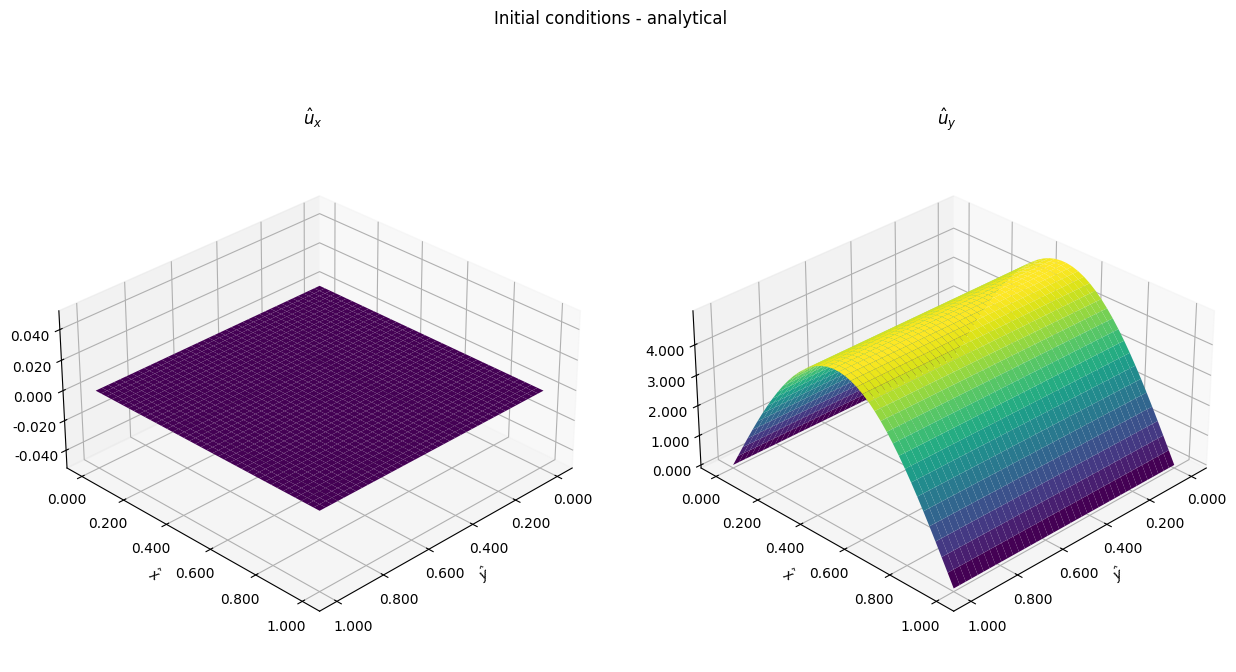

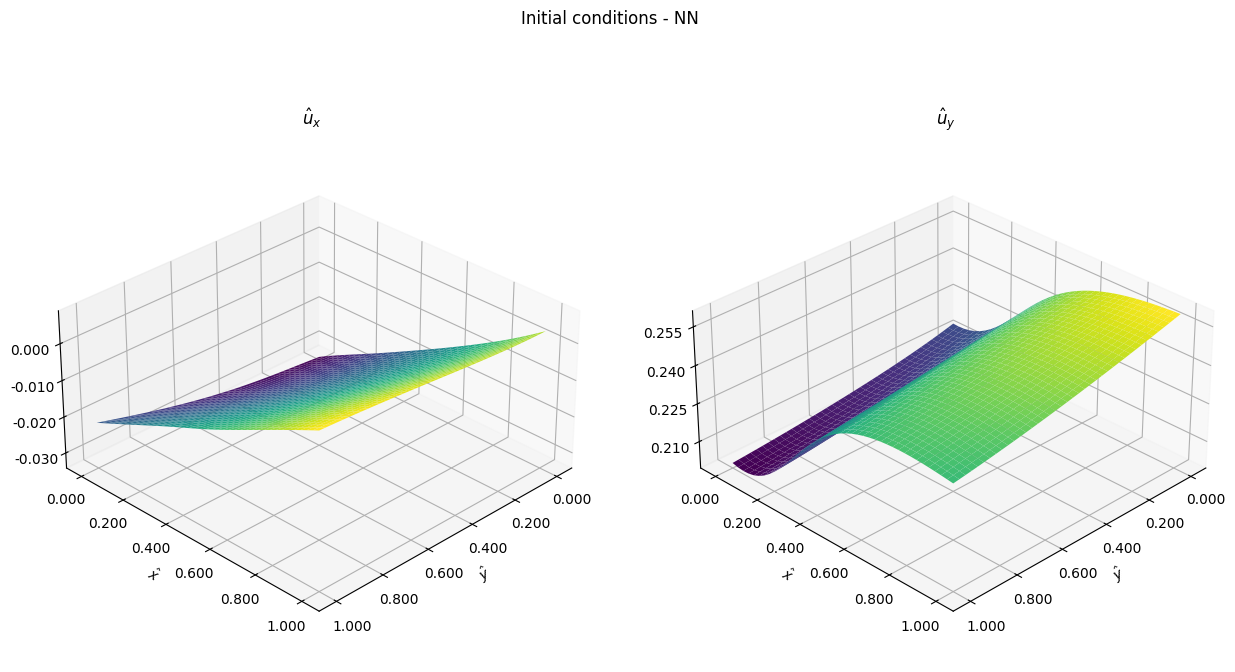

In [10]:
from plots import plot_initial_conditions, plot_uy

x, y, _ = get_initial_points(x_domain, y_domain, t_domain, n_train)
t_value = 0.0
t = torch.full_like(x, t_value)
x = x.to(device)
y = y.to(device)
t = t.to(device)
z = f(pinn_trained, x ,y, t)
ux_0, uy_0 = initial_conditions(x, y, Lx, i = 1)
z_0 = torch.cat((ux_0, uy_0), dim=1)

plot_initial_conditions(z_0, y, x, 'Initial conditions - analytical', n_train, from_pinn = 0)
plot_initial_conditions(z, y, x, 'Initial conditions - NN', n_train)

MovieWriter ffmpeg unavailable; using Pillow instead.


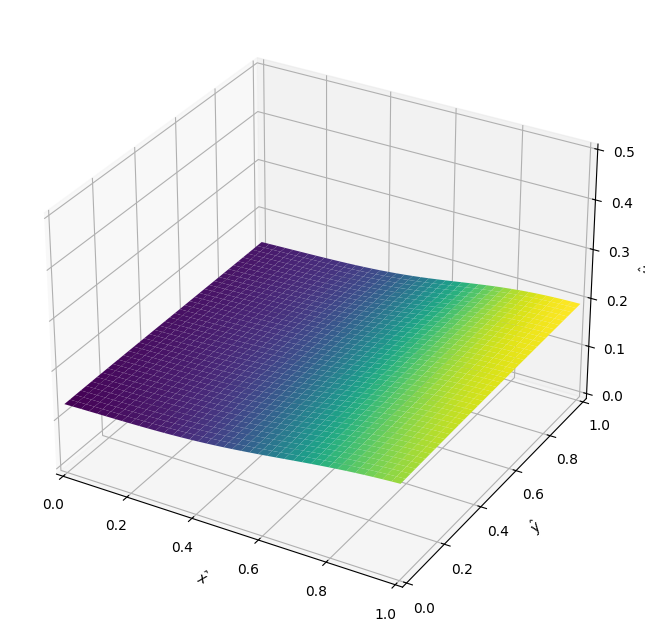

In [11]:
x, y, t = get_interior_points(x_domain, y_domain, t_domain, n_train)
plot_uy(pinn_trained, x, y, t, n_train)

# To be added
- ~separate loss in more bars to see how the various loss term come to zero~
- see if some quadrature rule has been implemented
- scheme of weights initialization in order to automatically satisfy initial conditions
- plots (in progress)
- NN operators (to generalize results)
- try to implement function that allows that satisfy initial conditions?

# To be fully understood
- reshape when plotting (also different number of points allowed?)
- ~not consistent initial conditions~ (between $u_x$ and $u_y$)?